ssd发表于2016年，其历史贡献是用多尺度特征图来做检测，其精度超过当时的faster rcnn，速度更是达到了1.7ms(nvidia TiTan X)。ssd训练模型，使得模型的各个特征图学会只对某个特定尺寸的目标负责，大特征图负责检测小目标，小特征图负责检测大目标。此外，ssd强调了数据集扩增对于one-stage模型的重要性，还提出一种random expand数据扩增方式，有效提升小目标检测精度。此外，还将空洞卷积引入网络结构，用于提升感受野。ssd缺点是对于小目标与相似物体检测效果较差。

ssd有两种网络结构，一种是ssd300，输入尺寸为300，另一种为ssd512，输入尺寸为512。ssd300整体结构如下图所示。与yolo对比，ssd采用多尺度策略来生成检测框。ssd采用vgg-16作为基础网络，去除classifier层，用conv_5作为第一个特征图，此后，加入5个特征图分别作为生成检测框的特征图，6个特征图尺寸分别为38x38,19x19,10x10,5x5,3x3,1x1。对于每个特征图的每个位置，预先定义若干anchor，每层anchor的尺寸、长宽比不一致。对于每个特征图的每个位置，利用3x3卷积生成类别置信度与坐标偏移量，每个位置的每个anchor都有自己的21个类别置信度与4个坐标偏移量，共计25维（在代码中，21个类别置信度与4个坐标偏移用两个3x3卷积分别生成）。
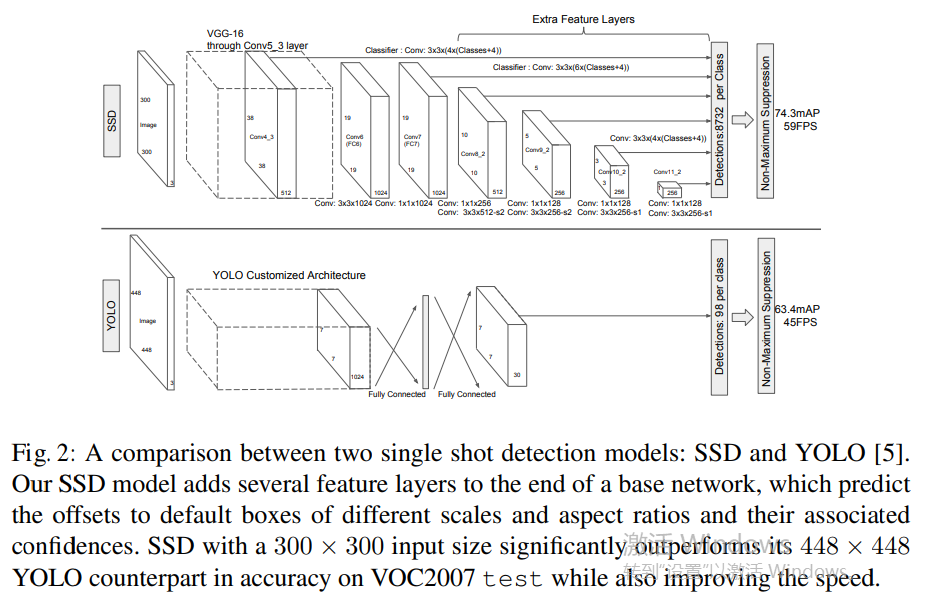

anchor生成<br/>
6个特征图，每个特征图生成的anchor尺寸不一样，以如下方式计算：
$$
s_k = s_{min} + \frac{s_{max} - s_{min}}{m-1}(k-1), k \in [1,m]
$$
$其中，m为特征图个数，k表示第k个特征图，s_{min}与s_{max}在文中设为0.2与0.9。s_k表示第\\k个特征图的anchor尺寸为原图的s_k，如第一张特征图为s_1 = 0.2，表示anchor尺寸为原图的\\0.2，即300*0.2=60,即第一张特征图anchor尺寸为60x60(注：代码中anchor尺寸的计算方式与\\论文有所不同)$<br/>
$长宽比a_r设为{1,2,3,1/2,1/3}，则每个anchor的w与h计算方式为：w_k^a = s_k\sqrt{a_r}，\\h_k^a=s_k/\sqrt{a_r}。$<br/>
$每个单元的anchor的中心点分布在该单元的中心，即(\frac{i+0.5}{|f_k|}, \frac{j+0.5}\
 {|f_k|})，\\ |f_k|为第k个特征图的尺寸，i,j \in [0, |f_k|)$<br/>
 每个特征图生成的anchor数量不同，分别为[4,6,6,6,4,4]，因此对于一幅图像,ssd共生成38x38x4+19x19x6+10x10x6+5x5x6+3x3x4+1x1x4=8732个检测框<br/>
 注：对于1x1的特征图，其anchor尺寸为264x264(代码中的计算方式),1x1特征图对应于原图，4个anchor代表以原图中心点为中心，长宽比不同、尺度为264x264的4个anchor。

loss函数<br/>
ssd对于正样本的选取原则是：首先对于每一个gt，选取与其jaccard overlap(其实就是iou)最大的那个anchor作为对应于该gt正样本，其次，对于剩下的anchor，只要与一个gt的iou大于阈值，也标记为对应于该anchor的正样本，只有正样本才参与loc loss的计算，所有正样本与负样本（经过hard negative mining后的）参与cls loss计算。总体loss计算公式如下：
$$
L(x,c,l,g) = \frac{1}{N}(L_{conf}(x,c) + \alpha L_{loc}(x,l,g))
$$
$其中，N为正样本数量，如果N=0,则loss为0.$<br/>
loc loss采用l1 smooth loss,只有正样本参与loc locc的计算。计算公式如下：
$$
L_{loc}(x,l,g) = \sum_{i \in Pos}^{N}{\sum_{m \in \{cx,cy,w,h\}}{x_{ij}^{k}smooth_{L1}(l_i^m - \hat g_j^m)}}
$$
$其中，cx与cy为相对anchor的偏移，w,h为log尺度相对相对anchor宽高：$
$$
\hat g_j^{cx} = (g_j^{cx} - d_i^{cx})/d_i^w \quad \hat g_j^{cy} = (g_j^{cy} - d_i^{cy})/d_i^h \\
\hat g_j^w = log(\frac{g_j^w}{d_i^w}) \quad \hat g_j^h = log(\frac{g_j^h}{d_i^h})
$$
confidence loss为softmax loss(cross entropy)，正负样本均参与计算：
$$
L_{conf}(x,c) = -\sum_{i \in Pos}^{N}{x_{ij}^{p}log(\hat c_i^p)}
$$
$其中，\hat c_i^p = \frac{exp(c_i^p)}{\sum_p{exp(c_i^p)}}$

hard negetive mining<br/>
anchor匹配之后，正负样本比例严重失衡，因此采用难例挖掘。选取对于confidence loss贡献大的前m个负样本，使得正负样本比例接近1:3.

多尺度特征图<br/>
ssd采用多尺度特征图生成预测框，使得每个特征图学会只对某些特定尺寸负责，大特征图负责小目标，小特征图负责大目标。如下图中，dog只在4x4特征图能够与anchor匹配，cat 只在8x8特征图有匹配。
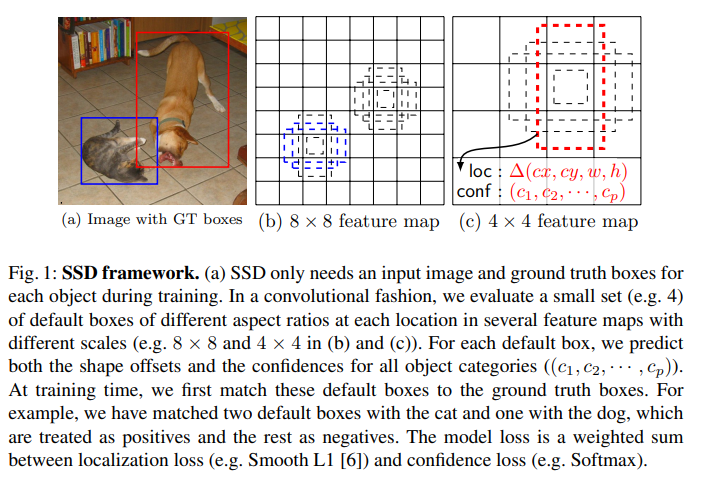

L2 norm<br/>
vgg基础网络的conv5，即第一个用于生成检测框的特征图，她的特征值与后面的特征图尺度不一致（如第一个特征图取值范围为[10，20]，后面特征图取值范围为[0.1.1]），因此采用l2 norm对第一个特征图进行归一化。

atrous conv<br/>
为了不降低特征图尺寸，作者采用了空洞卷积来代替传统卷积，同时增大感受野。

数据集扩增：<br/>
ssd采用的data aug方式包括：<br/>
1)随机裁剪：原图，裁剪一个与目标的iou值为0.1,0.3,0.5,0.7,0.9的区域，随机裁剪一个区域，即：
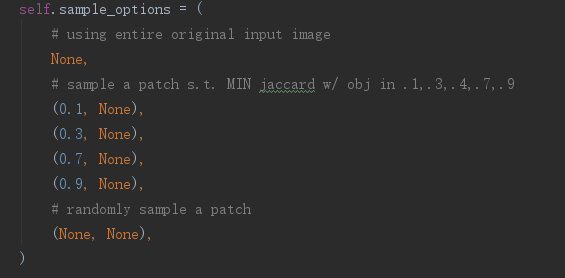
这些裁剪后的patch固定到统一尺寸，然后horizontal flip,随后应用photo-metric distortion<br/>

photo-metric distortion如下：
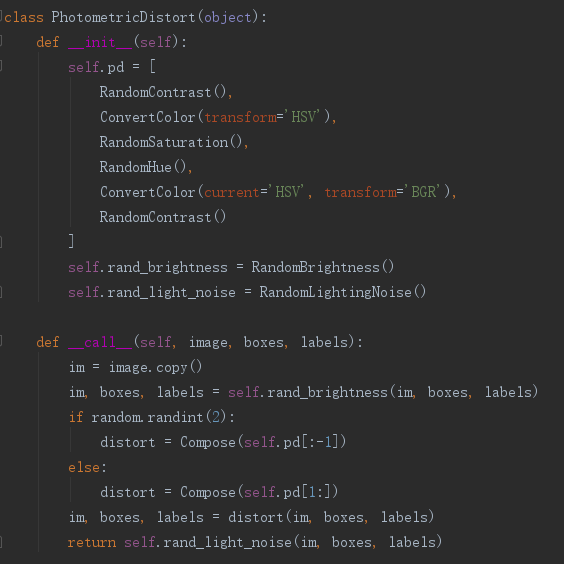

2）随机expand<br/>
将原图缩小，放置在一个更大的背景上，生成更多小目标，有效提高小目标检测精度。
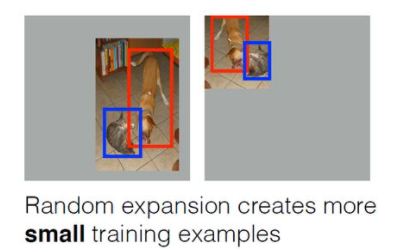